In [4]:
import numpy as np
import sys
sys.path.append('/home/painchess/projects_clean/Halo_Analytical_Calculations')
sys.path.append('/home/painchess/projects_clean/Simulations')
import simulation as sm
import cosmo_parameters as cp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

params = {'legend.fontsize': 7,
          'legend.handlelength': 2}
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['font.family'] = 'serif'
plt.rcParams.update(params)


# Paths and sims 

In [2]:
old_path = '/home/painchess/disq2/ahf-v1.0-101/'
path = '/home/painchess/sims/'

sim_names = ['M25S07', 'M25S08', 'M25S09', 'M03S07','M03S08', 'M03S09', 'M35S07', 'M35S08', 'M35S09',
             'Illustris', 'bolshoiP', 'bolshoiW', 'M03S08b', 'm25s85', 'm2s8', 'm4s7', 'm4s8', 'm2s9',
             'm3s8_50', 'm3s8', 'm35s75', 'm4s9', 'm3s9', 'm25s75', 'm2s1', 'm3s7', 'm3s85', 'm2s7', 'm25s8', 'm35s8', 'm25s9', 'm35s85', 'm3s75', 'm35s9', 'm35s7']
omegas = [0.25, 0.25, 0.25, 0.3, 0.3, 0.3, 0.35, 0.35, 0.35, 0.309, 0.307, 0.27, 0.3, 0.25, 0.2, 0.4, 0.4, 0.2,  0.3
          ,0.3, 0.35, 0.4, 0.3, 0.25, 0.2, 0.3, 0.3, 0.2, 0.25, 0.35, 0.25, 0.35, 0.3, 0.35, 0.35]
sigmas = [0.7, 0.8, 0.9, 0.7, 0.8, 0.9, 0.7, 0.8, 0.9, 0.816, 0.82, 0.82, 0.8, 0.85, 0.8, 0.7, 0.8, 0.9, 0.8
          ,0.8, 0.75, 0.9, 0.9, 0.75, 1.0, 0.7, 0.85, 0.7, 0.8, 0.8, 0.9, 0.85, 0.75, 0.9, 0.7]
sims = dict(zip(sim_names, list(zip(omegas, sigmas))))
def mcbride_mah(z, gamma, beta):
    return (1+z)**beta*np.exp(-gamma*z)

# RUNNING AGE PCA

## Simulation selection and loading data

In [3]:
sim = 'm3s85'
simo = sm.Simulation(sim, sims[sim][0], sims[sim][1], path)
halos = simo.read_halos()
reds = simo.get_redshifts()
mahpcs = np.loadtxt('./data/mah_pca_axes{}.txt'.format(sim)) 
sf = 1/(1+reds)
mahs = simo.get_mah()
nids = simo.get_mah_ids()
zdat, zmdat, mofzdat, othdat = simo.get_agedata(0,'zx'), simo.get_agedata(0,'zmm'), simo.get_agedata(0,'mofz'), simo.get_agedata(0,'oth')

halidxs = dict(zip(nids, np.arange(len(nids))))

## Cleaning data

In [4]:
czdat = zdat[np.isfinite(zdat['z1'])].reset_index()
czmdat = zmdat[np.isfinite(zdat['z1'])].reset_index()
cothdat = othdat[np.isfinite(zdat['z1'])].reset_index()

zxk = czdat.keys()[2:]
zmk = czmdat.keys()[2:]
mfzk = mofzdat.keys()[1:]

In [5]:
cdata = []
clmah = []
minlenmah = 100
clmah = np.zeros((len(cothdat), 72))
for i in range(len(cothdat)):
    haldat = []
    colnames = []
    hidx = cothdat['Halo_index'].loc[i]
    haln = halidxs[hidx]
    for k in zxk:
        haldat.append(czdat[k].loc[i])
        colnames.append(k)
    for k in zmk:
        haldat.append(czmdat[k].loc[i])
        colnames.append(k)
    for k in mfzk:
        haldat.append(mofzdat[k].loc[haln])
        colnames.append(k)
    haldat.append(cothdat['McBride_gamma'].loc[i]-cothdat['McBride_beta'].loc[i] )
    colnames.append(r'$\gamma-\beta$')
    #haldat.append(cothdat['McBride_beta'].loc[i])
    #colnames.append('McBride_beta')
    
    haldat.append(np.sum(mahs[haln][:min(80, len(mahs[haln]))]*mahpcs[0][:min(80, len(mahs[haln]))]/mahs[haln][0]))
    clmah[i, :] = mahs[haln][:72]/mahs[haln][0]
    if len(mahs[haln]) < minlenmah:
        minlenmah = len(mahs[haln])
    colnames.append('MAH-PC1')
    cdata.append(haldat)
    

In [22]:
cdata = np.array(cdata, dtype=np.float64)
cndata = (cdata - np.mean(cdata, axis=0))/np.std(cdata, axis=0)
dframe = pd.DataFrame(cndata, columns=colnames)

## Running PCA 

In [23]:
from sklearn.decomposition import PCA 
pca = PCA()
pca_fit = pca.fit_transform(dframe)

axes = pca.components_
exp_var = pca.explained_variance_
var_rat = pca.explained_variance_ratio_

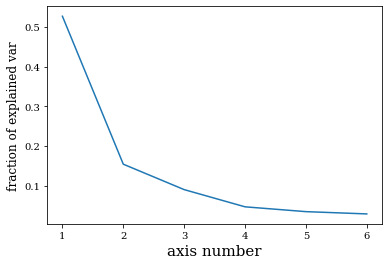

In [14]:
naxes=6
plt.plot(np.arange(1, naxes+1), var_rat[:naxes])
plt.xlabel("axis number", size=15)
plt.ylabel("fraction of explained var", size=12)
#plt.yscale('log')
plt.savefig('./figures/rat_explained_variance_ages_{}.png'.format(sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/rat_explained_variance_ages_{}.pdf'.format(sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

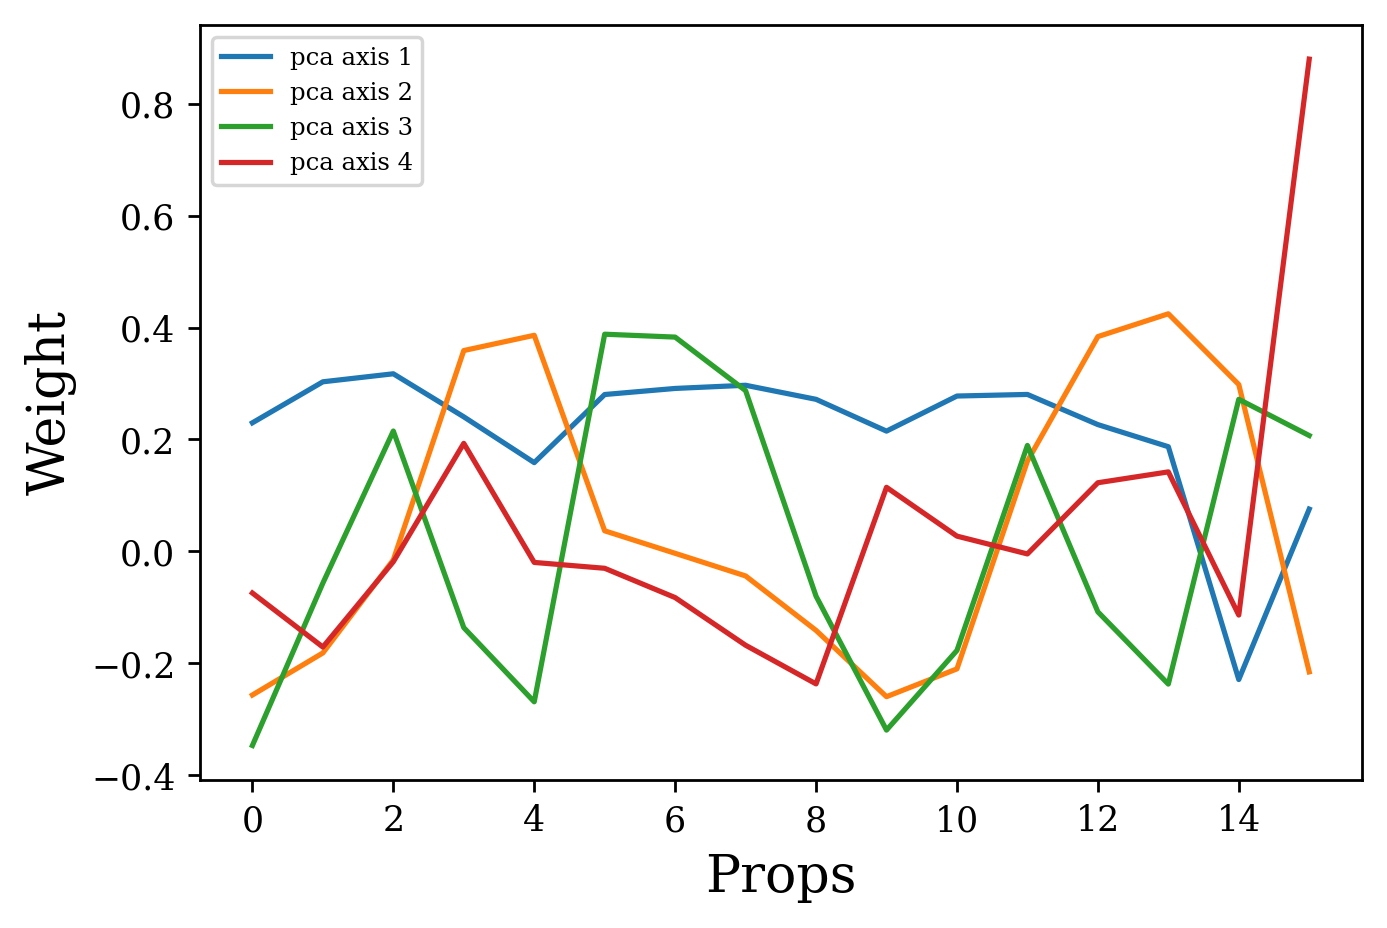

In [137]:
for i in range(4): 
    plt.plot(axes[i], label = "pca axis {}".format(i+1))
plt.xlabel('Props', size = 15)
plt.ylabel('Weight', size=15)
plt.legend()
#plt.savefig('ages_pca_decomp80_snaps_{}.png'.format(sim), facecolor='white', bbox_inches='tight',transparent=True, dpi=300)
#plt.savefig('ages_pca_decomp80_snaps_{}.pdf'.format(sim), facecolor='white', bbox_inches='tight',transparent=True, dpi=300)

In [19]:
import re
def plot_pca_bars(data, wts, ncomp, show_fig=True, save_fig=True, 
            print_hr_table=False, name='', lim=0.3):
    """ Make bar chart of PCA data, and put into TeX table """
    # Plotting PCA weights on bar chart, where
    # pca = PCA(n_components=ncom)
    # wts = pca.components_.T
    gap = 2.
    barWidth = 1./(ncomp+gap)
    # Set position of bar on X axis
    brs = [np.arange(len(wts))]
    for i in range(ncomp-1):
        brs += [[ii + barWidth for ii in brs[-1]]]
    
    colours = ['#57106e','#bc3754','#fca50a','#fcffa4', 'k']
    
    plt.figure(figsize=(6, 4.5))
    for i in range(ncomp):
        plt.bar(brs[i], wts[:,i], width = barWidth, label='PC%1d'%(i+1), 
                edgecolor='k', color='C{}'.format(i))
    plt.legend(fancybox=0, framealpha=1., edgecolor='w', loc=3)
    plt.xticks([r+0.5-(1.+gap)/(2.*(ncomp+gap)) for r in range(len(wts))], 
            data, rotation=-75)#tex_labels, rotation=-75)#
    plt.xlim(-0.75, len(wts)+0.25)
    plt.ylim(-0.8, 0.8)
    plt.xlabel('Age indicator')
    plt.ylabel('Coordinate value')
    for i in np.arange(1, len(wts)):
        plt.plot([i-(1.+gap)/(2.*(ncomp+gap)), i-(1.+gap)/(2.*(ncomp+gap))], 
                [-1., 1.], c='k', linewidth=1.)
    plt.plot([-0.75, len(wts)+0.25], [lim, lim], c='r', linewidth=1.)
    plt.plot([-0.75, len(wts)+0.25], [-lim, -lim], c='r', linewidth=1.)
    plt.tight_layout()
    if save_fig == True:
        plt.savefig('./figures/pca_bars{}.pdf'.format(name), bbox_inches='tight', dpi=450, facecolor='white', transparent=False)
        plt.savefig('./figures/pca_bars{}.png'.format(name), bbox_inches='tight', dpi=450, facecolor='white', transparent=False)
    if show_fig == True:
        plt.show()
    
    
    if print_hr_table==True:
        # Putting PCA weights in a human-readable table
        for i in range(len(data)):
            str_1 = data[i]
            replace = [m.start() for m in re.finditer('_', str_1)]
            str_1 = list(str_1)
            for n in replace:
                str_1[n] = '\\_'
            str_1 = ''.join(str_1)
            #str_1 = tex_labels[i]
            for j in wts[i]:
                if np.abs(j) > 0.3:
                    str_1 += (' & \\bf{%6.2f}' % j)
                else:
                    str_1 += (' & %6.2f' % j)
            str_1 += '\\\\'
            print(str_1)
    
    return None


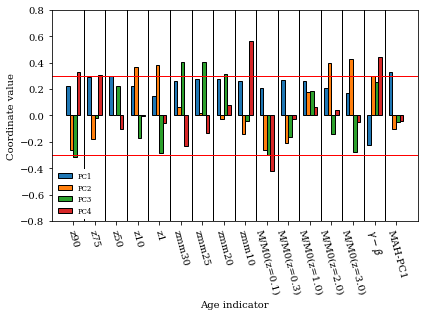

z90 &   0.22 &  -0.26 & \bf{ -0.32} & \bf{  0.33} &  -0.10 &  -0.10 &   0.04 & \bf{  0.68} &  -0.06 &   0.15 & \bf{ -0.30} &  -0.12 &   0.11 &  -0.22 &  -0.04 &  -0.03\\
z75 &   0.29 &  -0.18 &  -0.02 & \bf{  0.31} &   0.13 &  -0.00 &  -0.12 &  -0.24 &  -0.12 &   0.19 & \bf{  0.54} &   0.21 & \bf{  0.48} &  -0.24 &  -0.06 &  -0.17\\
z50 & \bf{  0.30} &   0.00 &   0.23 &  -0.10 &  -0.03 &   0.24 &   0.18 &  -0.03 &   0.22 &  -0.01 &   0.18 & \bf{ -0.60} &  -0.24 & \bf{ -0.34} &  -0.23 &  -0.28\\
z10 &   0.23 & \bf{  0.37} &  -0.17 &  -0.00 & \bf{ -0.42} &   0.04 &  -0.10 &  -0.07 &  -0.23 &   0.04 &  -0.01 & \bf{  0.44} & \bf{ -0.44} & \bf{ -0.36} &  -0.06 &  -0.13\\
z1 &   0.15 & \bf{  0.38} &  -0.29 &  -0.06 & \bf{  0.67} &  -0.00 & \bf{  0.32} &   0.07 & \bf{ -0.39} &  -0.19 &   0.01 &  -0.05 &  -0.03 &  -0.04 &  -0.03 &  -0.02\\
zmm30 &   0.26 &   0.06 & \bf{  0.40} &  -0.23 &   0.02 &  -0.12 &  -0.10 & \bf{  0.39} &   0.06 & \bf{ -0.39} &   0.18 &   0.15 &   0.09 &  -0.16 & \bf{  0

In [24]:
plot_pca_bars(colnames, axes.transpose(), 4, show_fig=True, save_fig=True, 
            print_hr_table=True)

## REDUCED AGE 

In [19]:
colnames

['z90',
 'z75',
 'z50',
 'z10',
 'z1',
 'zmm30',
 'zmm25',
 'zmm20',
 'zmm10',
 'M/M0(z=0.1)',
 'M/M0(z=0.3)',
 'M/M0(z=1.0)',
 'M/M0(z=2.0)',
 'M/M0(z=3.0)',
 '$\\gamma-\\beta$',
 'MAH-PC1']

In [16]:
newcols = ['z50', 'z1', 'zmm30', 'M/M0(z=0.1)', 'M/M0(z=3.0)', r'$\gamma-\beta$', 'MAH-PC1']
newdat = dframe[newcols]

In [17]:
from sklearn.decomposition import PCA 
#data = cleaned #shoulb be shape (npoints, nvariables) 
pca = PCA()
pca_fit = pca.fit_transform(newdat)

axes = pca.components_
exp_var = pca.explained_variance_
var_rat = pca.explained_variance_ratio_

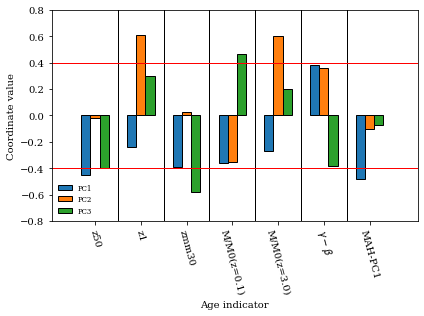

z50 & \bf{ -0.45} &  -0.02 & \bf{ -0.40} &  -0.14 &   0.29 & \bf{  0.35} & \bf{  0.64}\\
z1 &  -0.24 & \bf{  0.61} & \bf{  0.30} & \bf{ -0.61} & \bf{ -0.31} &  -0.00 &   0.04\\
zmm30 & \bf{ -0.39} &   0.03 & \bf{ -0.58} &   0.17 & \bf{ -0.55} & \bf{ -0.40} &  -0.14\\
M/M0(z=0.1) & \bf{ -0.36} & \bf{ -0.35} & \bf{  0.47} &   0.28 & \bf{ -0.50} & \bf{  0.44} &   0.07\\
M/M0(z=3.0) &  -0.27 & \bf{  0.60} &   0.20 & \bf{  0.67} &   0.27 &  -0.08 &   0.02\\
$\gamma-\beta$ & \bf{  0.38} & \bf{  0.36} & \bf{ -0.39} &   0.13 &  -0.24 & \bf{  0.68} &  -0.19\\
MAH-PC1 & \bf{ -0.48} &  -0.10 &  -0.07 &  -0.18 & \bf{  0.37} &   0.25 & \bf{ -0.72}\\


In [18]:
plot_pca_bars(newcols, axes.transpose(), 3, show_fig=True, save_fig=True, 
            print_hr_table=True, name='rest', lim=0.4)

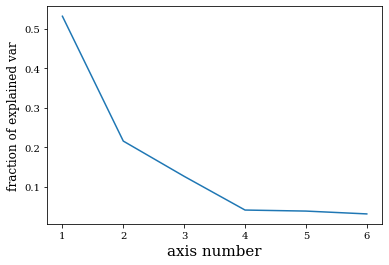

In [30]:
naxes=6
plt.plot(np.arange(1, naxes+1), var_rat[:naxes])
plt.xlabel("axis number", size=15)
plt.ylabel("fraction of explained var", size=12)
#plt.yscale('log')
plt.savefig('./figures/rat_explained_variance_ages_rest_{}.png'.format(sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/rat_explained_variance_ages_rest_{}.pdf'.format(sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

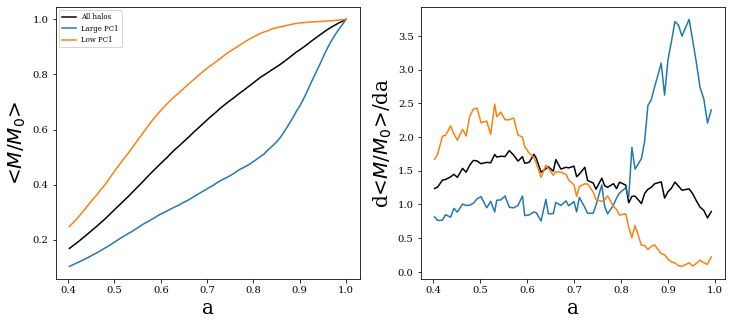

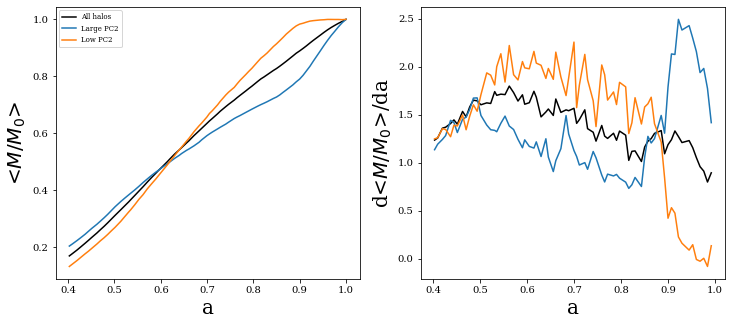

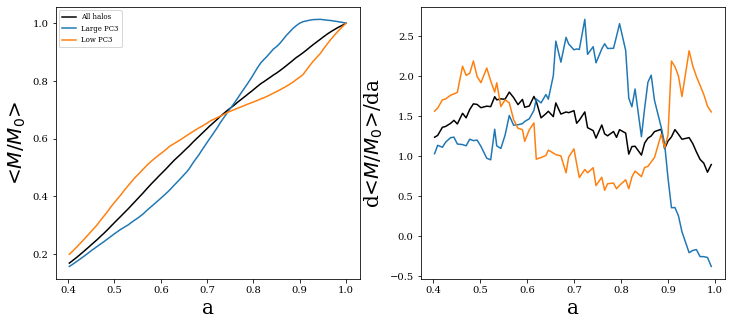

In [69]:
naxes = 3
for i in range(naxes):
    fig, axs = plt.subplots(1, 2, figsize=[12,5])
    axi = newdat.dot(axes[i])
    s1 = clmah[axi-np.mean(axi)>0.5*np.std(axi)]
    s2 = clmah[axi-np.mean(axi)<-0.5*np.std(axi)]
    #plt.plot(sf[:72], np.mean(clmah, axis=0), c='k', label='All halos')
    #plt.plot(sf[:72], np.mean(s1, axis=0), label='Large PC{}'.format(i+1))
    #plt.plot(sf[:72], np.mean(s2, axis=0), label='Low PC{}'.format(i+1))
    y1, y2, y3 = np.mean(clmah, axis=0), np.mean(s1, axis=0), np.mean(s2, axis=0)
    axs[0].plot(sf[:72], y1, c='k', label='All halos')
    axs[0].plot(sf[:72], y2, label='Large PC{}'.format(i+1))
    axs[0].plot(sf[:72], y3, label='Low PC{}'.format(i+1))
    axs[1].plot(sf[1:72], (y1[1:]-y1[:-1])/(sf[1:72]-sf[:71]), c='k')
    axs[1].plot(sf[1:72], (y2[1:]-y2[:-1])/(sf[1:72]-sf[:71]))
    axs[1].plot(sf[1:72], (y3[1:]-y3[:-1])/(sf[1:72]-sf[:71]))
    axs[0].set_xlabel('a', size=20)
    axs[1].set_xlabel('a', size=20)
    axs[0].set_ylabel(r'<$M/M_0$>', size=20)
    axs[1].set_ylabel(r'd<$M/M_0$>/da', size=20)
    axs[0].legend()
    plt.savefig('./figures/mean_mah_pc{}_ages_a_{}.png'.format(i+1, sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
    plt.savefig('./figures/mean_mah_pc{}_ages_a_{}.pdf'.format(i+1, sim), facecolor='white',  bbox_inches='tight',transparent=True, dpi=300)
# ax1 = c2.dot(axes[0])
# ax2 = c2.dot(axes[1])
# ax3 = c2.dot(axes[2])

In [50]:
cmap = mpl.cm.get_cmap('turbo')


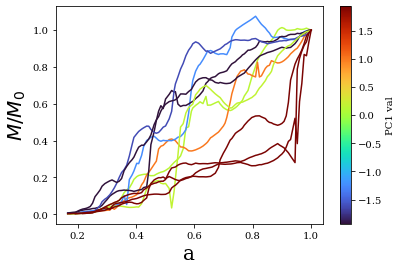

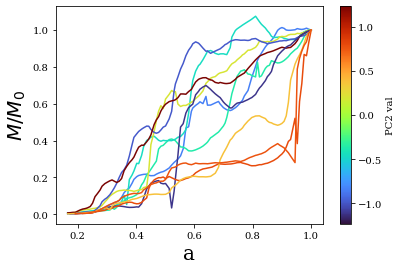

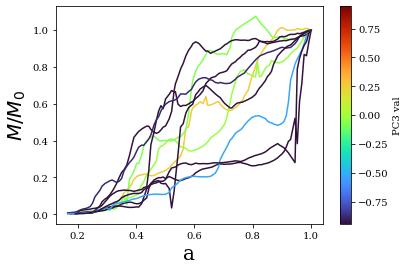

In [60]:
hls = []
for k in range(10):
    hls.append(np.random.randint(len(cothdat)))
for i in range(3):
    #axi = c2.dot(axes[i])
    axi = newdat.dot(axes[i])
    axmin, axmax = np.mean(axi)-np.std(axi), np.mean(axi)+np.std(axi)
    naxi = (axi-axmin)/(axmax-axmin)
    norm = mpl.colors.Normalize(vmin=axmin, vmax=axmax)
    smap = mpl.cm.ScalarMappable(norm, cmap)
    plt.figure()
    for hl in hls:
        hidx = cothdat['Halo_index'].loc[hl]
        haln = halidxs[hidx]
        nMAH = mahs[haln]/mahs[haln][0]
        plt.plot(sf[:len(nMAH)], nMAH, color=cmap(naxi[hl]))
    fig = plt.gcf()
    ax = plt.gca()
    fig.colorbar(smap, ax=ax, label='PC{} val'.format(i+1))
        #plt.plot(sf[:len(mahs[hl])], mahs[hl])
        #plt.yscale('log')
    plt.xlabel('a', size=20)
    plt.ylabel('$M/M_0$', size=20)
    plt.savefig('./figures/random_ages_colored_pc{}_{}.png'.format(i+1, sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
    plt.savefig('./figures/random_ages_colored_pc{}_{}.pdf'.format(i+1, sim), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

# Comparing cosmology

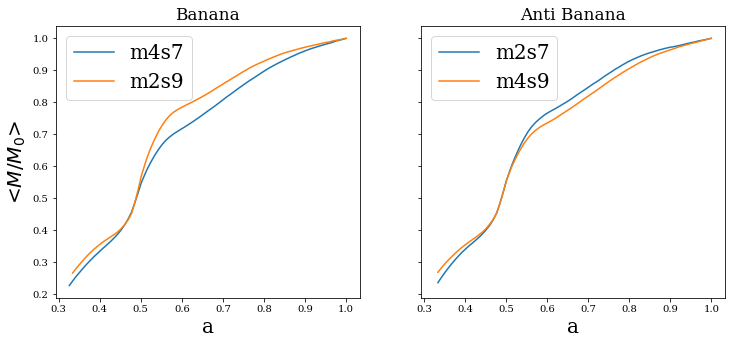

In [4]:
fig, axs = plt.subplots(1, 2, figsize=[12,5], sharex=True, sharey=True)
simselecs = [['m4s7', 'm2s9'], ['m2s7', 'm4s9']]
minlen = 80
z50min = 1
z50max = 1.1
zprop = 'z50'
for k in range(len(simselecs)):
    simselec = simselecs[k]
    for sim in simselec:
        simo = sm.Simulation(sim, sims[sim][0], sims[sim][1], path)
        reds = simo.get_redshifts()
        sf = 1/(1+reds)
        mahs = simo.get_mah()
        nids = simo.get_mah_ids()
        zdat = simo.get_agedata(0,'zx')
        othdat = simo.get_agedata(0,'oth')
        halidxs = dict(zip(nids, np.arange(len(nids))))
        idxs = np.array(othdat['Halo_index'][(zdat[zprop]>z50min)*(zdat[zprop]<z50max)])
        cmah = []
        for idx in idxs:
            i = halidxs[idx]
            if len(mahs[i])>minlen:
                cmah.append(mahs[i][:minlen]/mahs[i][0])
        cmah = np.array(cmah)
        x = sf[:minlen]
        y = np.mean(cmah, axis=0)
        axs[k].plot(x, y, label=sim)
        np.savetxt('./data/mean_mah_vs_a_z50_1_{}.txt'.format(sim), np.array([x, y], dtype=float).T)
    axs[k].set_xlabel('a', size=20)
axs[0].set_title('Banana', size=17)
axs[1].set_title('Anti Banana', size=17)
axs[0].set_ylabel(r'<$M/M_0$>', size=20)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
plt.savefig('./figures/mean_mah_{}_{}.png'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/mean_mah_{}_{}.pdf'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

In [5]:
def rc(z, om):
    return cp.rho_c*cp.hubble_ratio(z, omega_l0=1-om, omega_m0=om)

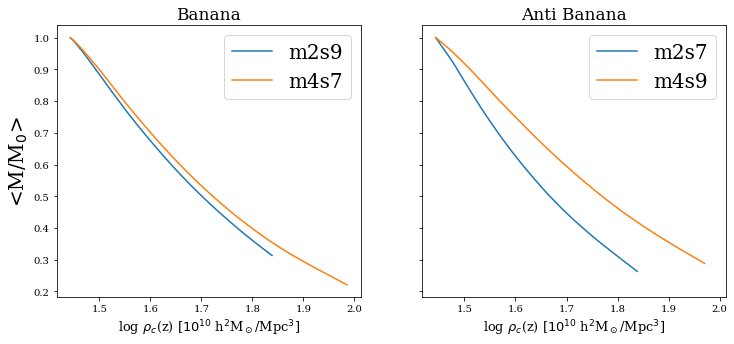

In [7]:
fig, axs = plt.subplots(1, 2, figsize=[12,5], sharex=True, sharey=True)
simselecs = [['m2s9', 'm4s7'], ['m2s7', 'm4s9']]
minlen = 80
z50min = 0
z50max = 2
zprop = 'z50'
for k in range(len(simselecs)):
    simselec = simselecs[k]
    for sim in simselec:
        simo = sm.Simulation(sim, sims[sim][0], sims[sim][1], path)
        reds = simo.get_redshifts()
        rcs = np.log10(rc(reds, simo.om0)/1e10)
        sf = 1/(1+reds)
        mahs = simo.get_mah()
        nids = simo.get_mah_ids()
        zdat = simo.get_agedata(0,'zx')
        othdat = simo.get_agedata(0,'oth')
        halidxs = dict(zip(nids, np.arange(len(nids))))
        idxs = np.array(othdat['Halo_index'][(zdat[zprop]>z50min)*(zdat[zprop]<z50max)])
        cmah = []
        for idx in idxs:
            i = halidxs[idx]
            if len(mahs[i])>minlen:
                cmah.append(mahs[i][:minlen]/mahs[i][0])
        cmah = np.array(cmah)
        x = rcs[:minlen]
        y = np.mean(cmah, axis=0)
        axs[k].plot(x, y, label=sim)
        np.savetxt('./data/mean_mah_vs_rho_crit_{}_{}.txt'.format(zprop, sim), np.array([10**(x+10), y], dtype=float).T)
    axs[k].set_xlabel(r'log $\rho_c$(z) [$10^{10}$ h$^2$M$_\odot$/Mpc$^3$]', size=13)
axs[0].set_title('Banana', size=17)
axs[1].set_title('Anti Banana', size=17)
axs[0].set_ylabel(r'<M/M$_0$>', size=20)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
plt.savefig('./figures/mean_mah_vs_rho_crit_{}_{}.png'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/mean_mah_vs_rho_crit_{}_{}.pdf'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

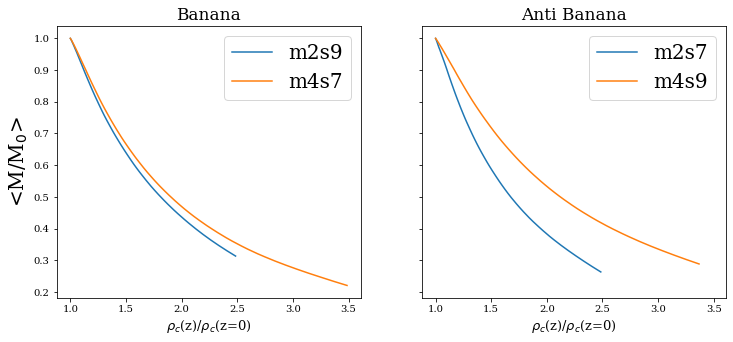

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[12,5], sharex=True, sharey=True)
simselecs = [['m2s9', 'm4s7'], ['m2s7', 'm4s9']]
minlen = 80
z50min = 0
z50max = 2
zprop = 'z50'
for k in range(len(simselecs)):
    simselec = simselecs[k]
    for sim in simselec:
        simo = sm.Simulation(sim, sims[sim][0], sims[sim][1], path)
        reds = simo.get_redshifts()
        rcs = rc(reds, simo.om0)/rc(0, simo.om0)
        sf = 1/(1+reds)
        mahs = simo.get_mah()
        nids = simo.get_mah_ids()
        zdat = simo.get_agedata(0,'zx')
        othdat = simo.get_agedata(0,'oth')
        halidxs = dict(zip(nids, np.arange(len(nids))))
        idxs = np.array(othdat['Halo_index'][(zdat[zprop]>z50min)*(zdat[zprop]<z50max)])
        cmah = []
        for idx in idxs:
            i = halidxs[idx]
            if len(mahs[i])>minlen:
                cmah.append(mahs[i][:minlen]/mahs[i][0])
        cmah = np.array(cmah)
        x = rcs[:minlen]
        y = np.mean(cmah, axis=0)
        axs[k].plot(x, y, label=sim)
        np.savetxt('./data/mean_mah_vs_rho_crit_norm_{}_{}.txt'.format(zprop, sim), np.array([x, y], dtype=float).T)

    axs[k].set_xlabel(r'$\rho_c$(z)/$\rho_c$(z=0)', size=13)
axs[0].set_title('Banana', size=17)
axs[1].set_title('Anti Banana', size=17)
axs[0].set_ylabel(r'<M/M$_0$>', size=20)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
plt.savefig('./figures/mean_mah_vs_rho_crit_norm_{}_{}.png'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/mean_mah_vs_rho_crit_norm_{}_{}.pdf'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)

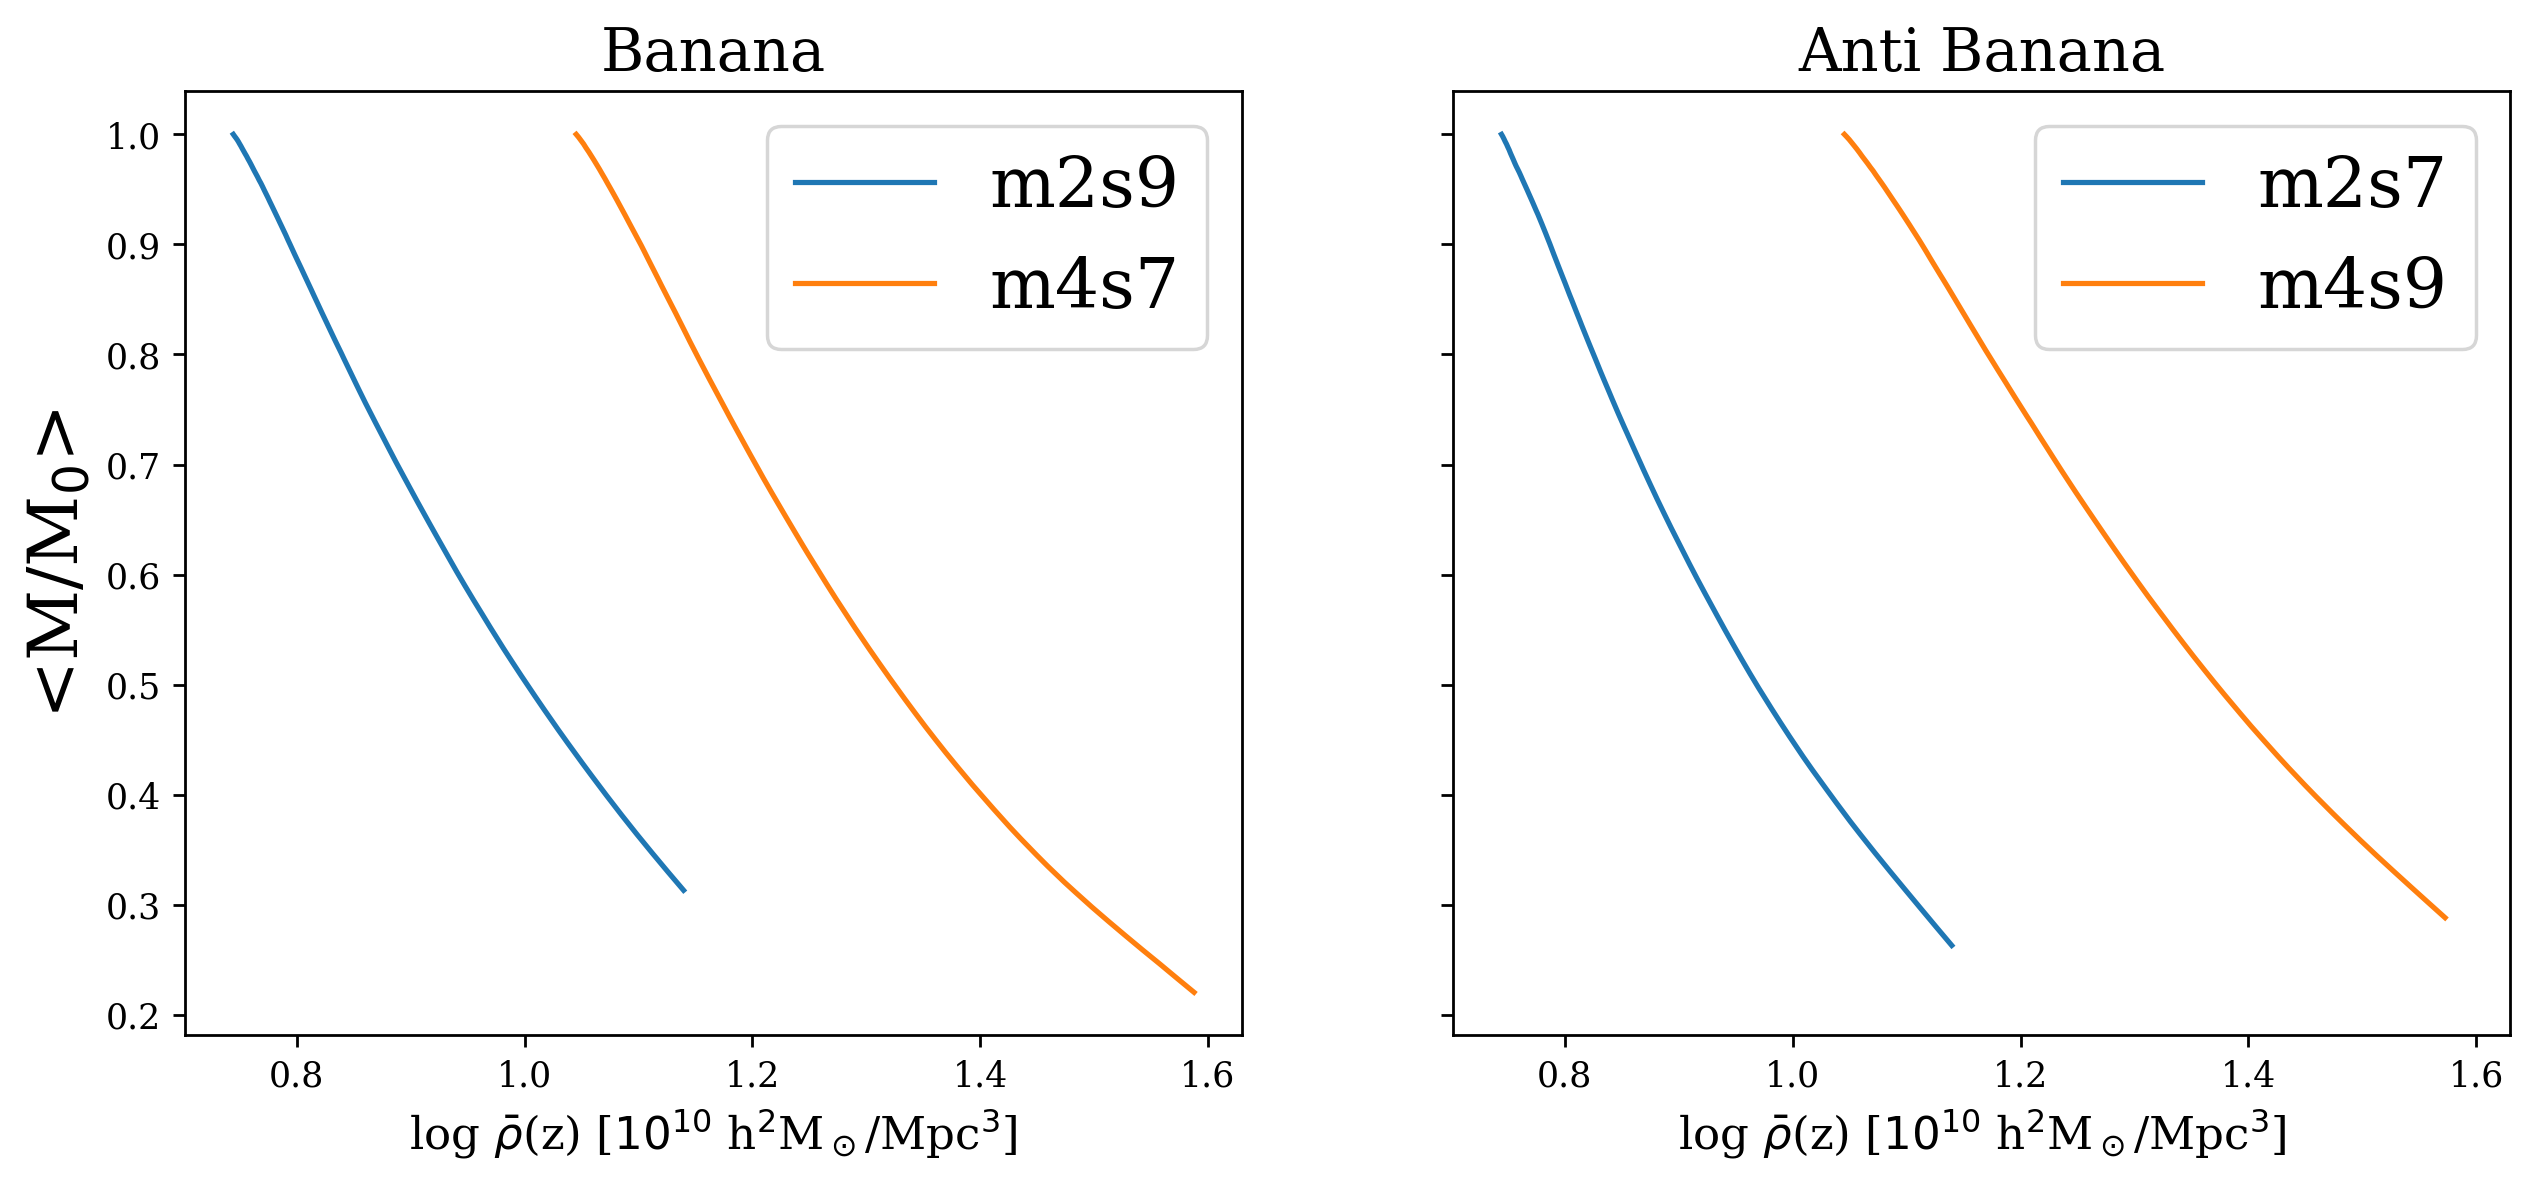

In [31]:
fig, axs = plt.subplots(1, 2, figsize=[12,5], sharex=True, sharey=True)
simselecs = [['m2s9', 'm4s7'], ['m2s7', 'm4s9']]
minlen = 80
z50min = 0
z50max = 2
zprop = 'z50'
for k in range(len(simselecs)):
    simselec = simselecs[k]
    for sim in simselec:
        simo = sm.Simulation(sim, sims[sim][0], sims[sim][1], path)
        reds = simo.get_redshifts()
        rcs = np.log10(simo.om0*rc(reds, simo.om0)/1e10)
        sf = 1/(1+reds)
        mahs = simo.get_mah()
        nids = simo.get_mah_ids()
        zdat = simo.get_agedata(0,'zx')
        othdat = simo.get_agedata(0,'oth')
        halidxs = dict(zip(nids, np.arange(len(nids))))
        idxs = np.array(othdat['Halo_index'][(zdat[zprop]>z50min)*(zdat[zprop]<z50max)])
        cmah = []
        for idx in idxs:
            i = halidxs[idx]
            if len(mahs[i])>minlen:
                cmah.append(mahs[i][:minlen]/mahs[i][0])
        cmah = np.array(cmah)
        axs[k].plot(rcs[:minlen], np.mean(cmah, axis=0), label=sim)
    axs[k].set_xlabel(r'log $\bar{\rho}$(z) [$10^{10}$ h$^2$M$_\odot$/Mpc$^3$]', size=13)
axs[0].set_title('Banana', size=17)
axs[1].set_title('Anti Banana', size=17)
axs[0].set_ylabel(r'<M/M$_0$>', size=20)
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
plt.savefig('./figures/mean_mah_vs_rho_ave_{}_{}.png'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)
plt.savefig('./figures/mean_mah_vs_rho_ave_{}_{}.pdf'.format(zprop, z50min), facecolor='white', bbox_inches='tight', transparent=True, dpi=300)